<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-1.2" data-toc-modified-id="Question-1.2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1.2</a></span></li><li><span><a href="#Question-1.3" data-toc-modified-id="Question-1.3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 1.3</a></span></li><li><span><a href="#Question-2.2" data-toc-modified-id="Question-2.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 2.2</a></span></li><li><span><a href="#Tests:-relabel,-evalbatch" data-toc-modified-id="Tests:-relabel,-evalbatch-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tests: relabel, evalbatch</a></span></li></ul></div>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import pandas as pd
plt.rcParams.update({'font.size': 18})

def eventfile_to_dict(file):
    output = {}
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag in output:
                output[v.tag].append(v.simple_value)
            else:
                output[v.tag] = [v.simple_value]
    return output

def plot_mean_std(x,ys,yerrors,labels):
    for i,label in enumerate(labels):
        plt.plot(x,ys[i])
        plt.fill_between(x,ys[i]-yerrors[i],ys[i]+yerrors[i],alpha=0.3,label=label)
    plt.legend()

## Question 1.2

In [15]:
eventfile.split('_')

['./run',
 'logs\\q1',
 'bc',
 'ant',
 'Ant-v4',
 '801',
 '13-09-2022',
 '03-20-12\\events.out.tfevents.1663039212.42f67933356e']

In [35]:
logdir = './run_logs/q1_*/events*'
target_trainstep = 1001
eval_returns = np.zeros((len(trainsteps),2))

# delete existing dataframe
df = pd.DataFrame()

for eventfile in glob.glob(logdir):
    task = eventfile.split('_')[4]
    trainstep = int(eventfile.split('_')[5])
    if trainstep == target_trainstep:
        result = eventfile_to_dict(eventfile)
        result['Task'] = task
        df_temp = pd.DataFrame.from_dict(result)[['Task', 'Eval_AverageReturn', 'Eval_StdReturn', 'Initial_DataCollection_AverageReturn']]
        df = df.append(df_temp, ignore_index=True)

df["Performance relative to expert"] = df["Eval_AverageReturn"] / df["Initial_DataCollection_AverageReturn"] * 100
df = df.round(2)
df["Performance relative to expert"] = df["Performance relative to expert"].apply(lambda x: str(x) + " %")
display(df.T)

,0,1
Task,Ant-v4,Walker2d-v4
Eval_AverageReturn,4383.54,327.8
Eval_StdReturn,206.76,384.64
Initial_DataCollection_AverageReturn,4713.65,5566.85
Performance relative to expert,93.0 %,5.89 %


## Question 1.3

{'Eval_AverageReturn': [4383.5361328125], 'Eval_StdReturn': [206.75662231445312], 'Eval_MaxReturn': [4752.91845703125], 'Eval_MinReturn': [4147.67236328125], 'Eval_AverageEpLen': [1000.0], 'Train_AverageReturn': [4713.6533203125], 'Train_StdReturn': [12.196533203125], 'Train_MaxReturn': [4725.849609375], 'Train_MinReturn': [4701.45654296875], 'Train_AverageEpLen': [1000.0], 'Train_EnvstepsSoFar': [0.0], 'TimeSinceStart': [8.478105545043945], 'Training_Loss': [-10.413163185119629], 'Initial_DataCollection_AverageReturn': [4713.6533203125]}
{'Eval_AverageReturn': [4303.79833984375], 'Eval_StdReturn': [66.45207214355469], 'Eval_MaxReturn': [4390.83740234375], 'Eval_MinReturn': [4194.4697265625], 'Eval_AverageEpLen': [1000.0], 'Train_AverageReturn': [4713.6533203125], 'Train_StdReturn': [12.196533203125], 'Train_MaxReturn': [4725.849609375], 'Train_MinReturn': [4701.45654296875], 'Train_AverageEpLen': [1000.0], 'Train_EnvstepsSoFar': [0.0], 'TimeSinceStart': [8.91358757019043], 'Training_L

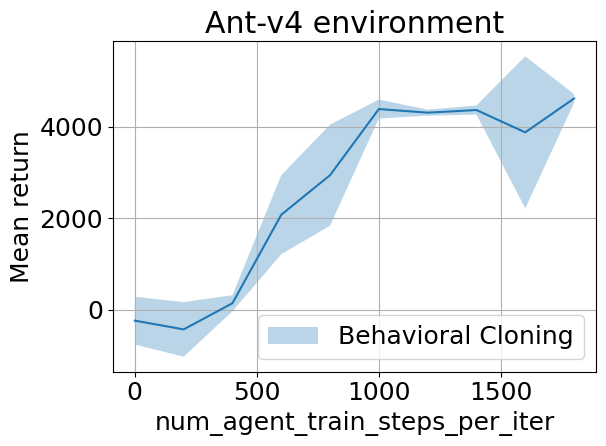

In [46]:
logdir = './run_logs/q1_bc_ant_*/events*'
trainsteps = list(range(1, 2000, 200))
eval_returns = np.zeros((len(trainsteps),2))
for eventfile in glob.glob(logdir):
    result = eventfile_to_dict(eventfile)
    print(result)
    trainstep = int(eventfile.split('_')[5])
    eval_returns[trainsteps.index(trainstep)] = [result['Eval_AverageReturn'][0],result['Eval_StdReturn'][0]]
    
plot_mean_std(trainsteps,[eval_returns[:,0]],[eval_returns[:,1]],['Behavioral Cloning'])
plt.xlabel('num_agent_train_steps_per_iter')
plt.ylabel('Mean return')
plt.title('Ant-v4 environment')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
# plt.savefig('./report/q1.3_ant_hyperparam.png',dpi=100)

## Question 2.2

In [36]:
df

,Task,Eval_AverageReturn,Eval_StdReturn,Initial_DataCollection_AverageReturn,Performance relative to expert
0,Ant-v4,4383.54,206.76,4713.65,93.0 %
1,Walker2d-v4,327.80,384.64,5566.85,5.89 %


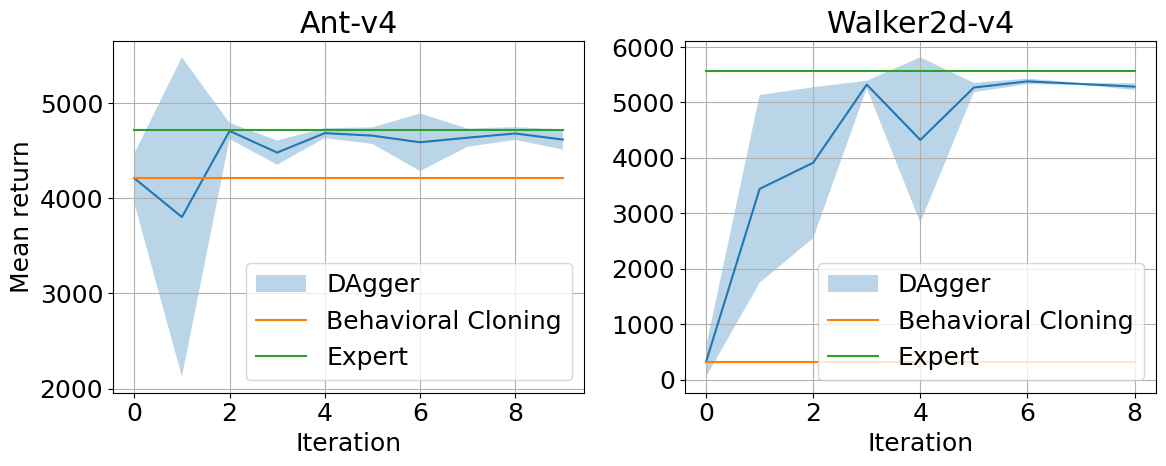

In [45]:
runs = ['Ant-v4','Walker2d-v4']
labels = ['DAgger']
plt.figure(figsize=(12,5))
for i,run in enumerate(runs):
    plt.subplot(1,2,i+1)
    logdir = f'./run_logs/q2_dagger_*{run}*/events*'
    result = eventfile_to_dict(glob.glob(logdir)[0])

    # DAgger
    eval_means = np.array([result['Eval_AverageReturn']])
    eval_stds= np.array([result['Eval_StdReturn']])
    n_iter = len(eval_means[0])
    plot_mean_std(range(n_iter),eval_means,eval_stds,labels)

    # BC & Expert
    plt.plot(result['Eval_AverageReturn'][0]*np.ones(n_iter),label='Behavioral Cloning')
    plt.plot(result['Initial_DataCollection_AverageReturn'],label='Expert')
    plt.title(run)
    plt.xlabel('Iteration')
    if i == 0:
        plt.ylabel('Mean return')
    plt.legend(loc='lower right')
    plt.grid()
plt.tight_layout()
plt.show()
# plt.savefig('../../report/q2.2_dagger.png',dpi=100)

## Tests: relabel, evalbatch

['../../data/q2_dagger_walker2d_relabel_Walker2d-v4_11-09-2022_11-58-23/events.out.tfevents.1662922703.Nams-Air.localdomain']
['../../data/q2_dagger_walker2d_norelabel_Walker2d-v4_11-09-2022_11-51-23/events.out.tfevents.1662922283.Nams-Air.localdomain']


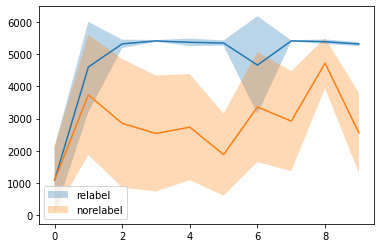

In [186]:
eval_means, eval_stds = [],[]
labels = ['relabel','norelabel']
for label in labels:
    logdir = f'../../data/q2_dagger_walker2d_{label}*/events*'
    print(glob.glob(logdir))
    result = eventfile_to_dict(glob.glob(logdir)[0])
    eval_means.append(result['Eval_AverageReturn'])
    eval_stds.append(result['Eval_StdReturn'])
eval_means = np.array(eval_means)
eval_stds = np.array(eval_stds)
plot_mean_std(range(len(eval_means[0])),eval_means,eval_stds,labels)


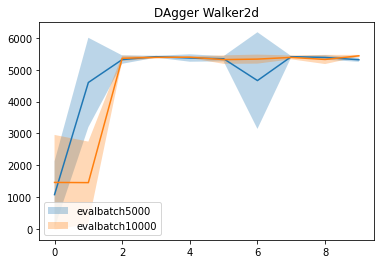

In [189]:
eval_means, eval_stds = [],[]
labels = ['evalbatch5000','evalbatch10000']
for label in labels:
    logdir = f'../../data/q2_dagger_walker2d_{label}*/events*'
    result = eventfile_to_dict(glob.glob(logdir)[0])
    eval_means.append(result['Eval_AverageReturn'])
    eval_stds.append(result['Eval_StdReturn'])
eval_means = np.array(eval_means)
eval_stds = np.array(eval_stds)
plot_mean_std(range(len(eval_means[0])),eval_means,eval_stds,labels)
plt.title('DAgger Walker2d')
plt.show()

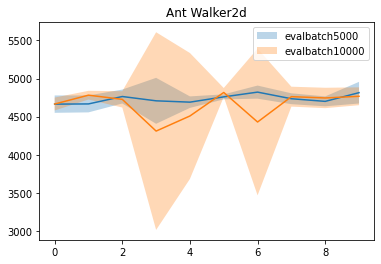

In [191]:
eval_means, eval_stds = [],[]
labels = ['evalbatch5000','evalbatch10000']
for label in labels:
    logdir = f'../../data/q2_dagger_ant_{label}*/events*'
    result = eventfile_to_dict(glob.glob(logdir)[0])
    eval_means.append(result['Eval_AverageReturn'])
    eval_stds.append(result['Eval_StdReturn'])
eval_means = np.array(eval_means)
eval_stds = np.array(eval_stds)
plot_mean_std(range(len(eval_means[0])),eval_means,eval_stds,labels)
plt.title('Ant Walker2d')
plt.show()

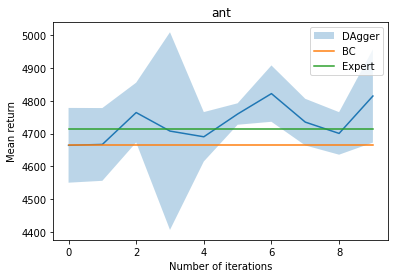

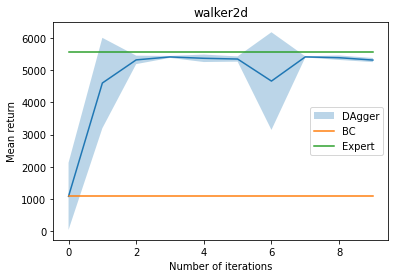